The goal of this project is to predict the number of nurses needed to provide service at MaCorp's virtual clinic. To do so, one needs to know how many end users need to receive service first. Therefore, from the provided data we find a way to forecast the daily number of chats and then using that number we recommend number of staff (nurses) needed to maintain users' satisfication while keeping the operational costs low (avoid over-staffing).

# 1- Chat forecast analysis

In the section, we provide some explanatory analysis and make some visualizations. This analysis is helpful for better understanding what kind of information exists in the data and how it could be exploited. Consequently, we made a maintable python module name `forecast` under hypothetical `macorp` parent module (outside this notebook).

## Prequisits/load modules

In [1]:
# Import [from] installed packages
import pandas as pd
import holidays
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from datetime import date
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
# import from local modules
from macorp.forecast.utils import extract_features_from_series

## Load data & extrac features

In [2]:
df = pd.read_csv('../data/chat_demand.csv', delimiter=',', index_col=0)
date_index = pd.to_datetime(df.index).date
# extracted_features = extract_features_from_series(date_index)
# for key, item in extracted_features.items():
#     df[key] = item
# feature_cols = list(extracted_features.keys())
# feature_cols += ['eligible_users']
# exclude test cases
df_train = df[~df['chats'].isnull()]

## Scaling bussiness

<AxesSubplot:title={'center':'Figure 1. Number of eligible users in the first half of 2017.'}, xlabel='date'>

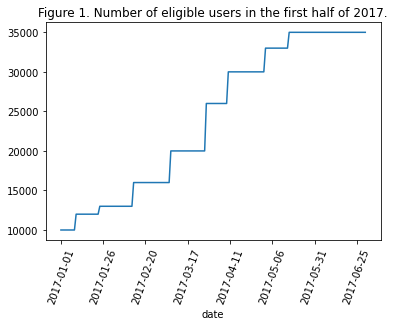

In [3]:
# visualize the trend of eligible users
df_train['eligible_users'].plot(rot=70, title='Figure 1. Number of eligible users in the first half of 2017.')

MaCorp's bussiness seems to be scaled up linearly in terms of number of clients in the first half of 2017. Since clients are defined under organizations, the jumps look normal (compared to a probably more smooth case of a bussiness that directly sells services to individuals). 

## Scaling service

With increasing the number of customers, the provided service needs to be scaled up so that the level of satisfication is maintained. Lets first look at the number of individuals who used the service in different days.

<AxesSubplot:title={'center':'Figure 2. Number of chats in the first half of 2017.'}, xlabel='date'>

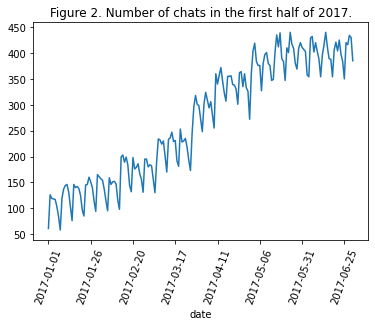

In [4]:
# visualize the trend of number of chats
df_train['chats'].plot(rot=70, title='Figure 2. Number of chats in the first half of 2017.')

A number of regulairties is visible with bare eyes just by looking at Figure 1 and Figure 2.
- The trend of using the service (number of chats) follows the trend of eligible users.
- If decomposed, signal of chats over time contains a large magnitude low-frequency component.

Lets first simplify our visual analysis by normalizing the number of chats by the number of eligible users so that the first visible regularity is ingested.

<AxesSubplot:title={'center':'Figure 3. Normalized number of chats in the first half of 2017.'}, xlabel='date'>

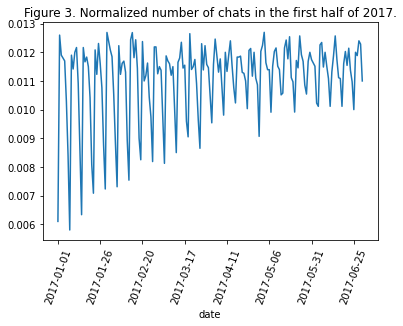

In [5]:
# visualize the trend of number of chats
normalized_chats = df_train['chats']/df_train['eligible_users']
normalized_chats.plot(rot=70, title='Figure 3. Normalized number of chats in the first half of 2017.')

Figure 3 implies that every few days once the normalized number of chats dropps and then goes back to normal. As we indicated above this regularity is repeated, e.g., there seem to be equal number of days between these drops in the the magnitude. In order to figure out why there is such a strong regularity in the signal, lets use different colors for days of the week and also show the holidays (of the Canadian Calendar) on the plot.

Text(0.5, 0.98, 'Figure 4. Normalized chats of different days of the week indicated with distinguishing colors.')

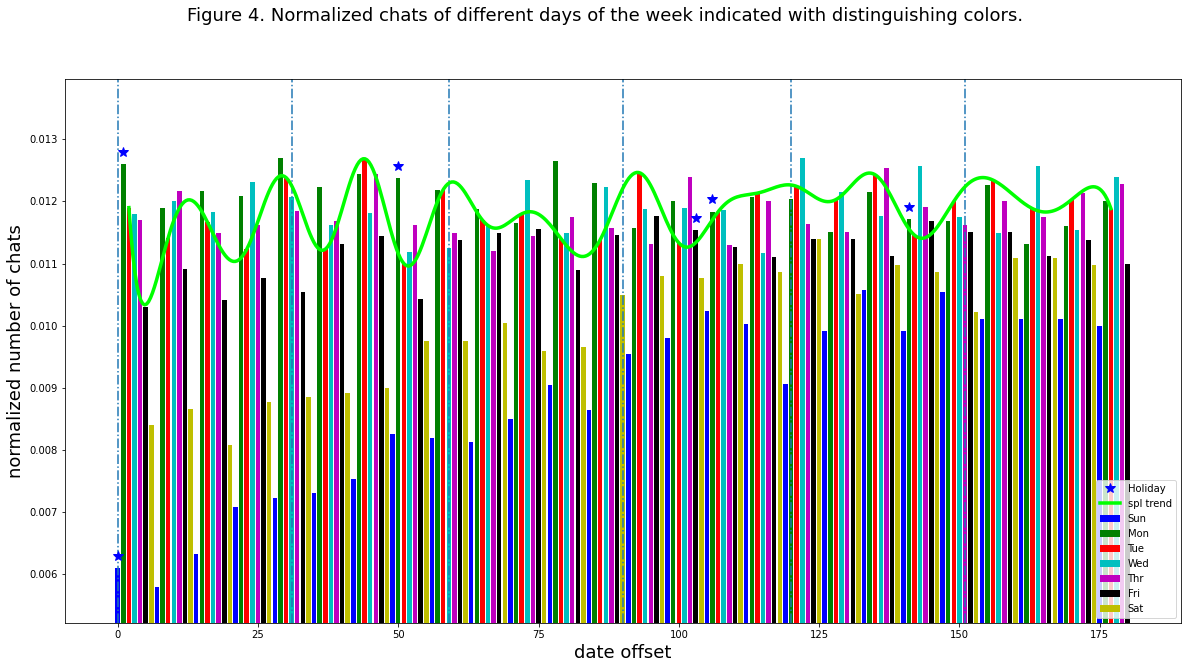

In [6]:
colors = ['b', 'g', 'r', 'c', 'm', 'k', 'y']
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat']
fig = plt.figure(figsize=(20,10))
min_y = 1
max_y = -1
for i in range(len(normalized_chats)):
    plt.bar(i, normalized_chats.iloc[i], color=colors[i%7], label=days[i] if i < 7 else None)
    if df_train.index[i][-2:] == '01':
        plt.axvline(i, linestyle='-.')
    min_y = min(normalized_chats.iloc[i], min_y)
    max_y = max(normalized_chats.iloc[i], max_y)

plt.ylim((min_y*0.9, max_y*1.1))

arrow_label_added = False
for date in holidays.Canada(years=2017):
    dt = str(date)
    if dt in df_train.index:
        x = df_train.index.get_loc(dt)
        plt.plot(x, normalized_chats[dt] + 0.0002, '*', label=None if arrow_label_added else 'Holiday', markersize=10, color='b')
        arrow_label_added = True

# smoooth line


only_wed = normalized_chats.iloc[2::7]

T = np.arange(0, len(only_wed))*7+2
xnew = np.linspace(T.min(), T.max(), 500)
spl = make_interp_spline(T, only_wed.values, k=5)  # type: BSpline
new_f = spl(xnew)
plt.plot(xnew, new_f, color=mcolors.CSS4_COLORS['lime'], label='spl trend', linewidth=3.5)
        

plt.xlabel('date offset', fontsize=18)
plt.ylabel('normalized number of chats', fontsize=18)
plt.legend()
plt.suptitle('Figure 4. Normalized chats of different days of the week indicated with distinguishing colors.', fontsize=18)

## Conclusion

A number of conclusions about the data could be made from Figure 4:
- The number of chats is significantly lower during the weekends compared to weekdays.
- Canadian holidays do not have a significant impact on the number of chats.
- It seems that given the day of the week, and the date offset (specially for weekends) a linear model can properly regress the data and make comparable accurate predictions (look at `macorp.forecast` package provided outside of this notebook).


A number of conclusions could be made with more data (more features or more data points):
- It is not clear whether the increase in the trend of service usage across consecutive weekends is due to customers realizing that the service is being offered on 24/7 basis or it is just related to the season (summer vs. winter). We need an indication of either (user awareness about the service or data for other years) to decide. 

# 2- Nurse Recommendation

Apart from training the staff on how the end customers should be treated, a key factor for maintaining customers' satisfication with the service is to keep their wait time reasonable. On the other hand, the company's operation should be profitable so we do not want to over-staff the virtual clinic. In the previous section we discussed about predicting workload at each day which could be used to predict the needed number of staff to handle the workload. This is a classic queue theory problem which is already well studies and resolved. In particular, **Erlang C** formula is often used in determining the number of agents for answering calls in a call centers. For chat platforms, some companies relax some assumptions and agents could reply to multiple customers at the same time; however, since healthcare is a sensitive domain (mixing iunformation of two patients could have catastrophic results) here we assume that one agent (nurse) serves a single end customer at each time without multiplexing. Our model for nurse recommendation requires the following extra information:
- average time to service each patient
- target average wait time: increasing this saves costs (lower number of staff is recommended) however declines patients' satisfication
- agent_refresh_fraction: this is the fraction of time agent is busy with self-care and refreshment
- satisfication level: this is a number between 0 and 1, telling the program for what percentage of the customers' the service and wait time would be satisfied in worse case scenario as expected.

The assumptions that this program makes are as follows:
1. Customer arrivals follow a Poisson distribution
2. Each nurse serves one patient at a time and the service time follows exponential distribution
3. Connected customers rarely leave before getting the service
4. Customers are queued in a first-in-first-out order
5. Number of chats does not have drastic changes during the day and night

We programmed this model along with chat prediction in `macorp.forecast` module.

## Points of improvement

Our program recommends number of nurses required for each working shift. However, clearly some working shifts and hours of the day and night are bussier than other so equally distributing staff in working shifts is not the best approach. One way of coping with this is to collect data for shorter periods of time (e.g., per hour or any period which assumption 5 above is better satisfied) so the number of nurses is properly recommended. It is also good to record average service-time ansd wait-time. 

---

# CLI demo

For documentation of the modules, methods and classes please click on [this link](../docs/macorp.html) to a pydoc generated html file (jupyter may block the request for security, in that case please open the file from `docs/macorp.html` in your browser).

**Locate in the root of project**

In [7]:
cd ..

C:\Users\Marzi\PycharmProjects\analytics-staffing-pjmpyj


**Install macorp's cli**

In [8]:
!pip install -e .

Obtaining file:///C:/Users/Marzi/PycharmProjects/analytics-staffing-pjmpyj
  Attempting uninstall: macorp.forecast
    Found existing installation: macorp.forecast 0.0.1
    Uninstalling macorp.forecast-0.0.1:
      Successfully uninstalled macorp.forecast-0.0.1
  Running setup.py develop for macorp.forecast


**print cli usage**

In [9]:
!macorp.forecast --help

Usage: macorp.forecast [OPTIONS] COMMAND [ARGS]...

  group definition for click commands. :return: None

Options:
  --help  Show this message and exit.

Commands:
  chat-forecast        predicts number of chats for a specific date.
  chat-forecast-batch  predicts number of chats for a batch of dates...
  staff-recom          Recommends number of nurses based on a single...
  staff-recom-batch    Recommends number of nurses based on a batch of...
  train-chat-forecast  Trains a regressor for predicting number of chats...


**train chat regressor**

In [10]:
!macorp.forecast train-chat-forecast -p data/chat_demand.csv -i

c:\users\marzi\pycharmprojects\analytics-staffing-pjmpyj\macorp\forecast\train.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = item


*a regressor is deployed under `deployment_models` and a visualization is provided considering some portion of training data as validation set.*

![pre_deployment_validation](../deployed_models/LinearRegression.neg_mean_absolute_error___2022-04-04.png)

In [11]:
deployed_model = "deployed_models/LinearRegression.neg_mean_absolute_error___2022-04-04.pkl"

**inference for a single date**

In [12]:
!macorp.forecast chat-forecast -d $deployed_model -t "2017-07-01" -e 35000

381


**batch inference**

In [13]:
!macorp.forecast chat-forecast-batch -p $deployed_model -d data/chat_demand.csv -i docs/chat_forecast_visual.png

381 371 491 481 471 462 452 442 432 491 481 471 461 451 441 431 514 504 494 485 475 465 455 513 504 494 484 474 464 454 513


![visualization](../docs/chat_forecast_visual.png)

**Nurse recommendation for single entry**

In [14]:
!macorp.forecast staff-recom --help

Usage: macorp.forecast staff-recom [OPTIONS]

  Recommends number of nurses based on a single demand entry (number of chats)
  and given corporate standards Example: # macorp.forecast staff-recom -c
  450 -h 20 -w 10 -r 0.1 -s 0.9

  :param chats: number of chats :param avg_handling_time: average time spent
  with a customer from when they are connected to a nurse :param wait_time:
  targeted wait time; increasing this number reduces operation costs of the
  company through recommending less number of nurses but a long time makes
  patients impatient! :param agent_refresh_fraction: fraction of time each
  nurse is expected to spend on refreshment. :param satisfaction: level of
  satisfaction of given criteria (0. to 1.) :return: None

Options:
  -c, --chats INTEGER RANGE       number of chats  [0<=x<=5000000; required]
  -h, --avg-handling-time FLOAT RANGE
                                  average handling time of a customer in
                                  minutes.  [0.0<=x<=200.0

In [15]:
!macorp.forecast staff-recom -c 450 -h 20 -w 10 -r 0.1 -s 0.9

10


**Batch nurse recommendation**

In [16]:
!macorp.forecast staff-recom-batch -p $deployed_model -d data/chat_demand.csv -h 20 -w 10 -r 0.1 -s 0.9 -i docs/nurse_recom.png

4 5 5 5 5 4 4 4 5 5 5 5 5 4 4 5 5 5 5 5 4 4 5 5 5 5 5 5 4 6 5 5 5 5 5 4 5 5 5 5 5 5 4 6 6 6 6 6 5 5 6 6 6 6 6 5 5 6 6 6 6 6 5 5 6 7 7 7 7 6 6 7 7 7 7 7 6 6 7 7 7 7 6 6 6 7 8 8 8 8 7 7 8 8 8 8 8 7 7 9 8 9 9 8 8 8 9 9 9 8 8 8 8 9 9 8 9 8 8 7 9 9 10 9 9 9 8 9 9 9 9 9 8 8 9 10 9 10 9 9 8 9 9 10 10 9 9 9 9 10 9 9 9 9 9 10 10 9 10 9 9 9 9 10 10 9 9 9 9 9 10 9 10 9 9 9 10 10 10 10 9
9 9 12 10 10 10 10 10 10 12 10 10 10 10 10 10 12 12 12 12 10 10 10 12 12 12 12 10 10 10 12


![nurse_visualization](../docs/nurse_recom.png)

*note that for the dates that chats column is null, first chats is predicted and then nurse is recommended based on that prediction.*

## Questions and answers

1. Include an exploratory data analysis and report any finding on the dataset.

> In this notebook we provided some exploratory data analysis. For forecasting number of daily chats, our analysis implies that the relation between variables and the target is linear. Therefor,e we used a pool of linear models (current filled with Linear regression and SVM, but easy to expand) to explore and find the best regressor.

2. Provide a recommendation on the number of nurses needed per day in July, please list the assumptions made to go from number of chats to number of nurses.


In [17]:
!macorp.forecast staff-recom-batch -p $deployed_model -d data/chat_demand_july_only.csv -h 20 -w 10 -r 0.1 -s 0.9

9 9 12 10 10 10 10 10 10 12 10 10 10 10 10 10 12 12 12 12 10 10 10 12 12 12 12 10 10 10 12


3. How would you evaluate the accuracy of your model?

> The number of required nurses (our final goal of chats forecast) is directly and linearly related to the number of chats. Therefore, it should be reasonable to meansure the performance by averaging the absolute error between predicted and true number of chats. 

4. If the team starts using this model to staff the clinic, how would you evaluate the impact of this change on MaCorp's operations?

> if the points of improvement tha we made is considered and/or using a control feedback system the number of nurses is adjusted, the costs of staffing should decrease noticeably assymptotically. Additionally, balancing work of the nurses would probably have positive impact on their own mental health which in turn could result in a better service.

5. What are the next steps to improve the model’s accuracy and its impact on costs and quality of service?

> As indicated, the data should be collected with more variables (average service time, average wait time, acceptable wait time, etc.) and in smaller granularity (than a whole day). This would result in more accurate analysis which would help more optimized planing and causes the costs of staffing to decrease.